In [26]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [4]:
import seaborn as sns
iris = sns.load_dataset('iris')

In [20]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [25]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

batchSize = 16

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


In [27]:
class theANNmodel(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)

        self.dr = dropoutRate

    def forward(self,x):
        x = F.relu(self.input(x))

        x = F.dropout(x, p=self.dr, training=self.training)

        x = F.relu(self.hidden(x))

        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)

        return x

In [43]:
class theANNmodelNA(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)

        self.dr = dropoutRate

    def forward(self,x):
        x = self.input(x)

        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.hidden(x)

        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)

        return x

In [28]:
tmpnet = theANNmodel(.25)

tmpdata = torch.randn((10,4))

yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.0956, -0.2149,  0.1972],
        [ 0.3213, -0.5190,  0.2263],
        [ 0.0759, -0.1909,  0.2569],
        [ 0.1276, -0.2334,  0.1750],
        [ 0.1457, -0.3649,  0.1900],
        [ 0.1797, -0.3088,  0.1185],
        [ 0.0561, -0.1881,  0.3769],
        [ 0.1210, -0.2584,  0.2540],
        [ 0.3106, -0.3914,  0.0574],
        [ 0.1233, -0.3041,  0.1935]], grad_fn=<AddmmBackward0>)

In [30]:
def createANNmodel(dropoutRate):
    ANN = theANNmodel(dropoutRate)

    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.005)

    return ANN, lossfun, optimizer

In [44]:
def createANNmodelNA(dropoutRate):
    ANN = theANNmodelNA(dropoutRate)

    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.005)

    return ANN, lossfun, optimizer

In [45]:
numEpochs = 1000

def trainTheModel(ANN):
    trainAcc = []
    testAcc = []

    for epochi in range(numEpochs):
        ANN.train()

        batchAcc = []
        for X, y in train_loader:
            yHat = ANN(X)

            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))

        ANN.eval()
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANN(X), axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
    
    return trainAcc, testAcc

In [48]:
dropoutRate = .0

ANN, lossfun, optimizer = createANNmodel(dropoutRate)

trainAcc, testAcc = trainTheModel(ANN)

In [49]:
ANN, lossfun, optimizer = createANNmodelNA(dropoutRate)

trainAcc, testAcc = trainTheModel(ANN)

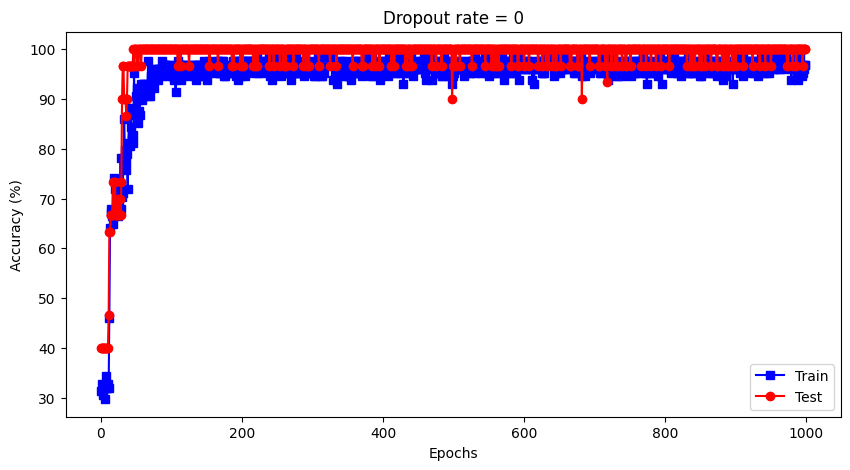

In [50]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutRate)

plt.show()

In [51]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for dp in range(len(dropoutRates)):
    ANN, lossfun, optimizer = createANNmodelNA(dropoutRates[dp])
    trainAcc, testAcc = trainTheModel(ANN)

    results[dp,0] = np.mean(trainAcc[-50:])
    results[dp,1] = np.mean(testAcc[-50:])


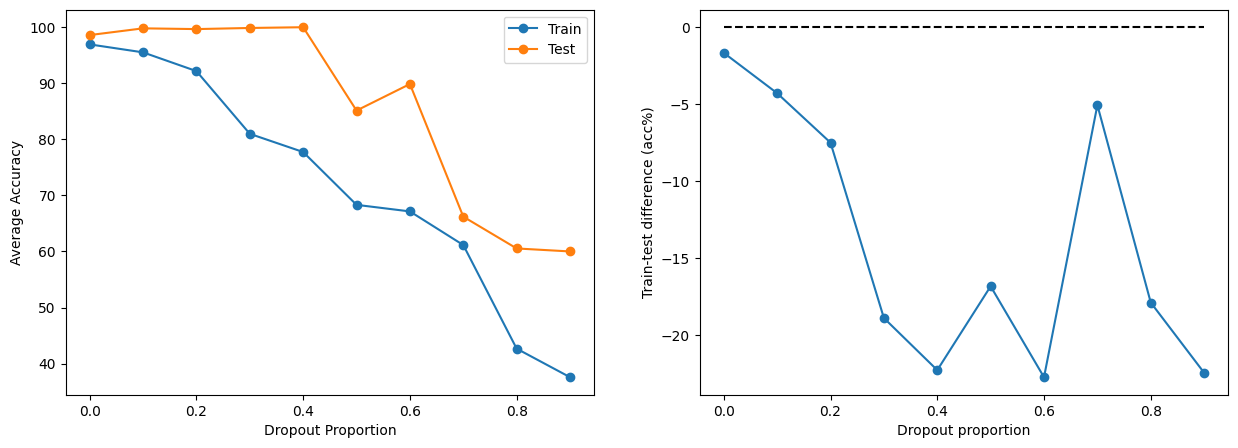

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout Proportion')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results,axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

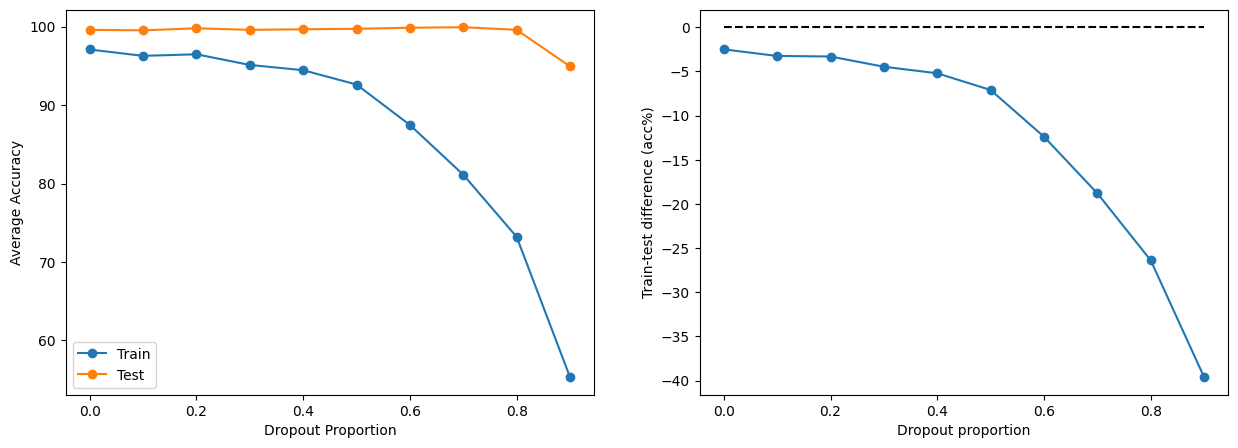

In [52]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout Proportion')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results,axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()